In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset
import numpy as np
import copy
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from itertools import cycle
import seaborn as sns
import os
from PIL import Image
import torchvision.transforms as transforms
import zipfile

In [ ]:
# Configs
NUM_CLIENTS = 5
NUM_EPOCHS = 30
BATCH_SIZE = 16  # Smaller batch size due to varying image sizes
LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [ ]:
# 📁 Upload kaggle.json
from google.colab import files
files.upload()  # Upload kaggle.json when prompted

# 🔑 Configure Kaggle API
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# 📥 Download and Extract Kvasir-SEG Dataset
!kaggle datasets download -d debeshjha1/kvasirseg
with zipfile.ZipFile("kvasirseg.zip", 'r') as zip_ref:
    zip_ref.extractall("kvasir-seg")

Dataset URL: https://www.kaggle.com/datasets/debeshjha1/kvasirseg
License(s): copyright-authors
 86% 124M/144M [00:00<00:00, 1.26GB/s]
100% 144M/144M [00:00<00:00, 1.20GB/s]


In [ ]:
# Transforms for Kvasir-SEG
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to fixed size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB image
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to fixed size
    transforms.ToTensor()  # Convert to tensor, no normalization
])

In [ ]:
# Custom Dataset for Kvasir-SEG
class KvasirSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])  # Masks are also .jpg

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Binary mask

        # Apply transforms with consistent random seed for resizing
        if self.image_transform and self.mask_transform:
            seed = np.random.randint(2147483647)
            random.seed(seed)
            torch.manual_seed(seed)
            image = self.image_transform(image)
            random.seed(seed)
            torch.manual_seed(seed)
            mask = self.mask_transform(mask)

        # Convert mask to binary (0 or 1)
        mask = (mask > 0.5).float()  # Already a tensor, threshold at 0.5
        return image, mask

In [ ]:
# Load Kvasir-SEG
dataset = KvasirSegDataset(
    image_dir='/content/kvasir-seg/Kvasir-SEG/Kvasir-SEG/images',
    mask_dir='/content/kvasir-seg/Kvasir-SEG/Kvasir-SEG/masks',
    image_transform=image_transform,
    mask_transform=mask_transform
)

In [ ]:
# Split into train/validation/test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# CNN-based Segmentation Model (U-Net inspired)
class CNNSeg(nn.Module):
    def __init__(self):
        super(CNNSeg, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2), nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=3, padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# LeNet-inspired Segmentation Model
class LeNetSeg(nn.Module):
    def __init__(self):
        super(LeNetSeg, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, padding=2), nn.ReLU(), nn.AvgPool2d(2),
            nn.Conv2d(6, 16, kernel_size=5, padding=2), nn.ReLU(), nn.AvgPool2d(2),
            nn.Conv2d(16, 32, kernel_size=5, padding=2), nn.ReLU(), nn.AvgPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(8, 4, kernel_size=2, stride=2), nn.ReLU(),
            nn.Conv2d(4, 1, kernel_size=3, padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# Dataset Split for Clients
def split_dataset(dataset, num_clients):
    size = len(dataset) // num_clients
    indices = np.random.permutation(len(dataset))
    return [Subset(dataset, indices[i * size:(i + 1) * size]) for i in range(num_clients)]

client_datasets = split_dataset(train_dataset, NUM_CLIENTS)

In [ ]:
# Metrics Tracking
def compute_metrics(model, loader):
    model.eval()
    correct = 0
    total = 0
    loss = 0.0
    dice_scores = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = model(x)
            loss += F.binary_cross_entropy(preds, y, reduction='sum').item()

            # Binarize predictions
            pred_labels = (preds > 0.5).float()

            # Pixel accuracy
            correct += (pred_labels == y).float().sum().item()
            total += y.nelement()

            # Dice score per image in batch
            intersection = (pred_labels * y).sum(dim=(2, 3))
            union = pred_labels.sum(dim=(2, 3)) + y.sum(dim=(2, 3))
            dice = (2. * intersection + 1e-8) / (union + 1e-8)
            dice_scores.extend(dice.cpu().numpy().tolist())  # Extend with list of Dice scores

            all_preds.extend(pred_labels.flatten().cpu().numpy())
            all_labels.extend(y.flatten().cpu().numpy())

    accuracy = 100. * correct / total if total > 0 else 0.0
    avg_loss = loss / total if total > 0 else 0.0
    avg_dice = np.mean(dice_scores) if dice_scores else 0.0
    return accuracy, avg_loss, avg_dice, np.array(all_labels), np.array(all_preds)

In [ ]:
# Plotting Functions
def plot_metrics(train_metrics, val_metrics, test_metrics, model_name, method):
    epochs = range(1, NUM_EPOCHS + 1)

    # Accuracy Plot
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_metrics['acc'], label='Train Accuracy')
    plt.plot(epochs, val_metrics['acc'], label='Validation Accuracy')
    plt.plot(epochs, test_metrics['acc'], label='Test Accuracy')
    plt.title(f'{model_name} {method} Accuracy (Kvasir-SEG)')
    plt.xlabel('Epoch')
    plt.ylabel('Pixel Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{model_name}_{method}_accuracy_kvasirseg.png')
    plt.close()

    # Loss Plot
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_metrics['loss'], label='Train Loss')
    plt.plot(epochs, val_metrics['loss'], label='Validation Loss')
    plt.plot(epochs, test_metrics['loss'], label='Test Loss')
    plt.title(f'{model_name} {method} Loss (Kvasir-SEG)')
    plt.xlabel('Epoch')
    plt.ylabel('BCE Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{model_name}_{method}_loss_kvasirseg.png')
    plt.close()

    # Dice Score Plot
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_metrics['dice'], label='Train Dice')
    plt.plot(epochs, val_metrics['dice'], label='Validation Dice')
    plt.plot(epochs, test_metrics['dice'], label='Test Dice')
    plt.title(f'{model_name} {method} Dice Score (Kvasir-SEG)')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{model_name}_{method}_dice_kvasirseg.png')
    plt.close()

def plot_roc_curve(labels, preds, model_name, method):
    fpr, tpr, _ = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} {method} ROC Curve (Kvasir-SEG)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig(f'{model_name}_{method}_roc_kvasirseg.png')
    plt.close()

def plot_confusion_matrix(labels, preds, model_name, method):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Background', 'Polyp'], yticklabels=['Background', 'Polyp'])
    plt.title(f'{model_name} {method} Confusion Matrix (Kvasir-SEG)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'{model_name}_{method}_cm_kvasirseg.png')
    plt.close()

In [ ]:
# Dice Loss Function
def dice_loss(pred, target):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return 1 - (2. * intersection + 1e-8) / (union + 1e-8)

# FedAvg Training
def fedavg_train(model_class, model_name):
    global_model = model_class().to(DEVICE)
    print(f"\n🔁 Training FedAvg with {model_name} on Kvasir-SEG")

    train_metrics = {'acc': [], 'loss': [], 'dice': []}
    val_metrics = {'acc': [], 'loss': [], 'dice': []}
    test_metrics = {'acc': [], 'loss': [], 'dice': []}

    for epoch in range(NUM_EPOCHS):
        local_weights = []
        for client_data in client_datasets:
            model = copy.deepcopy(global_model)
            model.to(DEVICE)
            optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
            loader = DataLoader(client_data, batch_size=BATCH_SIZE, shuffle=True)
            model.train()
            for x, y in loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                optimizer.zero_grad()
                preds = model(x)
                bce_loss = F.binary_cross_entropy(preds, y)
                dice = dice_loss(preds, y)
                loss = 0.5 * bce_loss + 0.5 * dice
                loss.backward()
                optimizer.step()
            local_weights.append(copy.deepcopy(model.state_dict()))

        global_model.load_state_dict(average_weights(local_weights))

        # Compute metrics
        train_acc, train_loss, train_dice, _, _ = compute_metrics(global_model, train_loader)
        val_acc, val_loss, val_dice, _, _ = compute_metrics(global_model, val_loader)
        test_acc, test_loss, test_dice, labels, preds = compute_metrics(global_model, test_loader)

        train_metrics['acc'].append(train_acc)
        train_metrics['loss'].append(train_loss)
        train_metrics['dice'].append(train_dice)
        val_metrics['acc'].append(val_acc)
        val_metrics['loss'].append(val_loss)
        val_metrics['dice'].append(val_dice)
        test_metrics['acc'].append(test_acc)
        test_metrics['loss'].append(test_loss)
        test_metrics['dice'].append(test_dice)

        print(f"Epoch {epoch+1}, FedAvg {model_name} - Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Test Acc: {test_acc:.2f}%, Test Dice: {test_dice:.4f}")

        # Plot ROC and Confusion Matrix for final epoch
        if epoch == NUM_EPOCHS - 1:
            plot_roc_curve(labels, preds, model_name, 'FedAvg')
            plot_confusion_matrix(labels, preds, model_name, 'FedAvg')

    plot_metrics(train_metrics, val_metrics, test_metrics, model_name, 'FedAvg')
    return global_model, test_metrics['dice'][-1]

In [ ]:
# FML-Proxy Training
def fml_proxy_train(model_class, model_name):
    print(f"\n🔁 Training FML-Proxy with {model_name} on Kvasir-SEG")
    priv_models = [model_class().to(DEVICE) for _ in range(NUM_CLIENTS)]
    proxy_models = [model_class().to(DEVICE) for _ in range(NUM_CLIENTS)]

    train_metrics = {'acc': [], 'loss': [], 'dice': []}
    val_metrics = {'acc': [], 'loss': [], 'dice': []}
    test_metrics = {'acc': [], 'loss': [], 'dice': []}

    for epoch in range(NUM_EPOCHS):
        for i in range(NUM_CLIENTS):
            client_data = client_datasets[i]
            priv = priv_models[i]
            proxy = proxy_models[i]

            priv.train()
            proxy.train()

            priv_opt = torch.optim.Adam(priv.parameters(), lr=LEARNING_RATE)
            proxy_opt = torch.optim.Adam(proxy.parameters(), lr=LEARNING_RATE)
            loader = DataLoader(client_data, batch_size=BATCH_SIZE, shuffle=True)

            for x, y in loader:
                x, y = x.to(DEVICE), y.to(DEVICE)

                # Proxy update using ensemble
                with torch.no_grad():
                    ensemble = torch.zeros_like(y).to(DEVICE)
                    for j, other in enumerate(priv_models):
                        if j != i:
                            other.eval()
                            ensemble += other(x)
                    ensemble /= (NUM_CLIENTS - 1)

                proxy_preds = proxy(x)
                loss_proxy = F.binary_cross_entropy(proxy_preds, ensemble)
                proxy_opt.zero_grad()
                loss_proxy.backward()
                proxy_opt.step()

                # Private update using proxy + true labels
                priv_preds = priv(x)
                with torch.no_grad():
                    proxy_preds = proxy(x)

                loss_kd = F.binary_cross_entropy(priv_preds, proxy_preds)
                bce_loss = F.binary_cross_entropy(priv_preds, y)
                dice = dice_loss(priv_preds, y)
                loss_ce = 0.5 * bce_loss + 0.5 * dice
                loss = 0.7 * loss_kd + 0.3 * loss_ce

                priv_opt.zero_grad()
                loss.backward()
                priv_opt.step()

        # Compute average metrics across clients
        train_accs, train_losses, train_dices = [], [], []
        val_accs, val_losses, val_dices = [], [], []
        test_accs, test_losses, test_dices = [], [], []
        all_labels, all_preds = [], []

        for priv in priv_models:
            train_acc, train_loss, train_dice, _, _ = compute_metrics(priv, train_loader)
            val_acc, val_loss, val_dice, _, _ = compute_metrics(priv, val_loader)
            test_acc, test_loss, test_dice, labels, preds = compute_metrics(priv, test_loader)

            train_accs.append(train_acc)
            train_losses.append(train_loss)
            train_dices.append(train_dice)
            val_accs.append(val_acc)
            val_losses.append(val_loss)
            val_dices.append(val_dice)
            test_accs.append(test_acc)
            test_losses.append(test_loss)
            test_dices.append(test_dice)
            all_labels.extend(labels)
            all_preds.extend(preds)

        train_metrics['acc'].append(np.mean(train_accs))
        train_metrics['loss'].append(np.mean(train_losses))
        train_metrics['dice'].append(np.mean(train_dices))
        val_metrics['acc'].append(np.mean(val_accs))
        val_metrics['loss'].append(np.mean(val_losses))  # Fixed typo: val_cards -> val_losses
        val_metrics['dice'].append(np.mean(val_dices))
        test_metrics['acc'].append(np.mean(test_accs))
        test_metrics['loss'].append(np.mean(test_losses))
        test_metrics['dice'].append(np.mean(test_dices))

        print(f"Epoch {epoch+1}, FML-Proxy {model_name} - Train Acc: {np.mean(train_accs):.2f}%, Val Acc: {np.mean(val_accs):.2f}%, Test Acc: {np.mean(test_accs):.2f}%, Test Dice: {np.mean(test_dices):.4f}")

        # Plot ROC and Confusion Matrix for final epoch
        if epoch == NUM_EPOCHS - 1:
            plot_roc_curve(np.array(all_labels), np.array(all_preds), model_name, 'FML-Proxy')
            plot_confusion_matrix(np.array(all_labels), np.array(all_preds), model_name, 'FML-Proxy')

    plot_metrics(train_metrics, val_metrics, test_metrics, model_name, 'FML-Proxy')
    return priv_models, np.mean(test_dices)

In [ ]:
# FedAvg Aggregation
def average_weights(state_dicts):
    avg = copy.deepcopy(state_dicts[0])
    for k in avg.keys():
        for i in range(1, len(state_dicts)):
            avg[k] += state_dicts[i][k]
        avg[k] = avg[k] / len(state_dicts)
    return avg

In [ ]:
# Train and Compare
def compare_models():
    print("\n🚀 Training and Comparing CNNSeg and LeNetSeg on Kvasir-SEG")

    # Train CNNSeg
    cnn_fed_model, cnn_fed_dice = fedavg_train(CNNSeg, "CNNSeg")
    cnn_fml_models, cnn_fml_dice = fml_proxy_train(CNNSeg, "CNNSeg")

    # Train LeNetSeg
    lenet_fed_model, lenet_fed_dice = fedavg_train(LeNetSeg, "LeNetSeg")
    lenet_fml_models, lenet_fml_dice = fml_proxy_train(LeNetSeg, "LeNetSeg")

    # Comparison
    print(f"\n✅ Final Results:")
    print(f"CNNSeg FedAvg Test Dice: {cnn_fed_dice:.4f}")
    print(f"CNNSeg FML-Proxy Average Test Dice: {cnn_fml_dice:.4f}")
    print(f"LeNetSeg FedAvg Test Dice: {lenet_fed_dice:.4f}")
    print(f"LeNetSeg FML-Proxy Average Test Dice: {lenet_fml_dice:.4f}")

    # Bar Plot for Comparison
    models = ['CNNSeg FedAvg', 'CNNSeg FML-Proxy', 'LeNetSeg FedAvg', 'LeNetSeg FML-Proxy']
    dice_scores = [cnn_fed_dice, cnn_fml_dice, lenet_fed_dice, lenet_fml_dice]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=models, y=dice_scores)
    plt.title('Model Comparison - Test Dice Score (Kvasir-SEG)')
    plt.ylabel('Dice Score')
    plt.xticks(rotation=45)
    plt.savefig('model_comparison_kvasirseg.png')
    plt.close()


In [ ]:
# Run the comparison
compare_models()


🚀 Training and Comparing CNNSeg and LeNetSeg on Kvasir-SEG

🔁 Training FedAvg with CNNSeg on Kvasir-SEG
Epoch 1, FedAvg CNNSeg - Train Acc: 84.88%, Val Acc: 84.01%, Test Acc: 83.90%, Test Dice: 0.0000
Epoch 2, FedAvg CNNSeg - Train Acc: 84.88%, Val Acc: 84.01%, Test Acc: 83.90%, Test Dice: 0.0000
Epoch 3, FedAvg CNNSeg - Train Acc: 84.88%, Val Acc: 84.01%, Test Acc: 83.90%, Test Dice: 0.0000
Epoch 4, FedAvg CNNSeg - Train Acc: 84.88%, Val Acc: 84.01%, Test Acc: 83.90%, Test Dice: 0.0000
Epoch 5, FedAvg CNNSeg - Train Acc: 84.88%, Val Acc: 84.00%, Test Acc: 83.89%, Test Dice: 0.0001
Epoch 6, FedAvg CNNSeg - Train Acc: 84.87%, Val Acc: 83.99%, Test Acc: 83.89%, Test Dice: 0.0001
Epoch 7, FedAvg CNNSeg - Train Acc: 84.87%, Val Acc: 83.99%, Test Acc: 83.88%, Test Dice: 0.0001
Epoch 8, FedAvg CNNSeg - Train Acc: 84.86%, Val Acc: 83.98%, Test Acc: 83.87%, Test Dice: 0.0001
Epoch 9, FedAvg CNNSeg - Train Acc: 84.62%, Val Acc: 83.73%, Test Acc: 83.65%, Test Dice: 0.0446
Epoch 10, FedAvg CNNSe

Displaying: CNNSeg_FedAvg_accuracy_kvasirseg.png


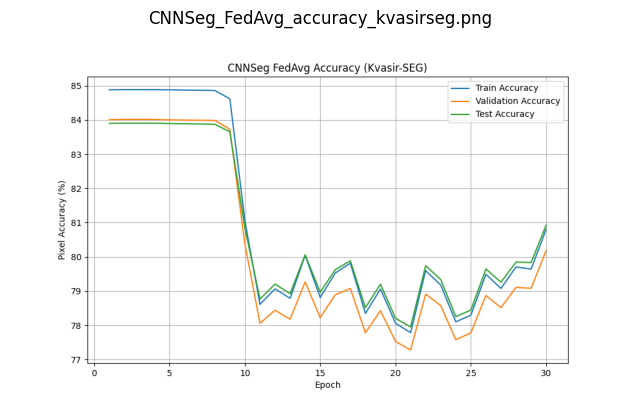

Displaying: CNNSeg_FedAvg_loss_kvasirseg.png


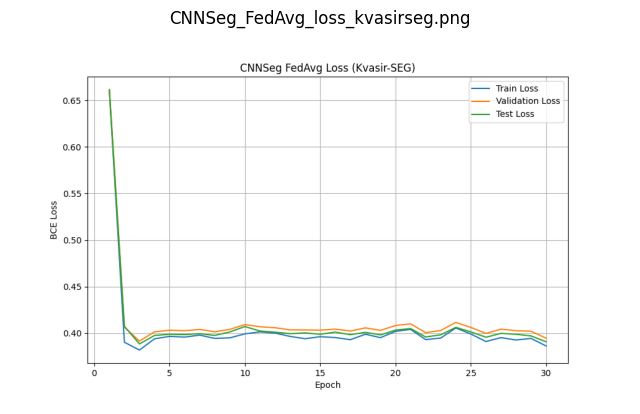

Displaying: CNNSeg_FedAvg_roc_kvasirseg.png


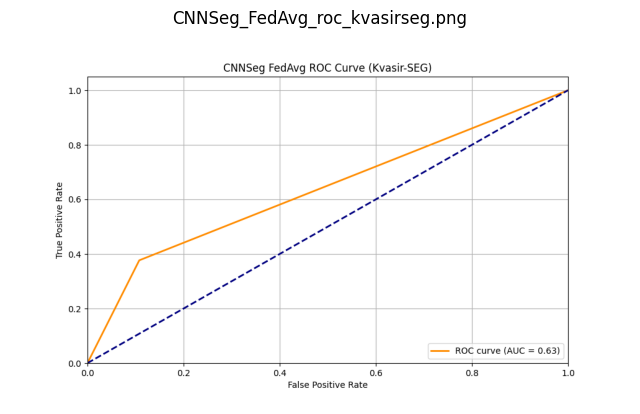

Displaying: CNNSeg_FedAvg_cm_kvasirseg.png


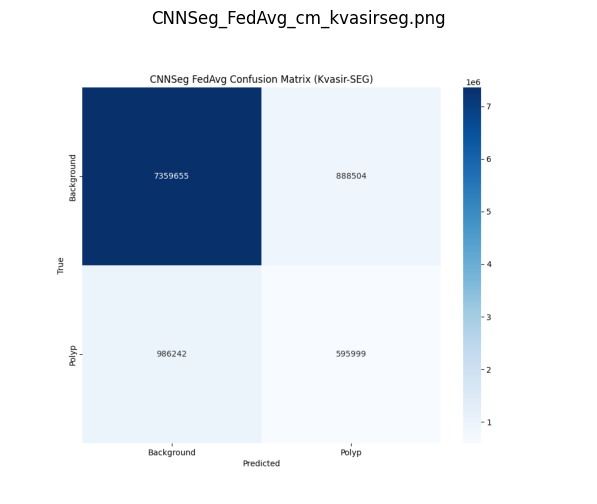

Displaying: CNNSeg_FML-Proxy_accuracy_kvasirseg.png


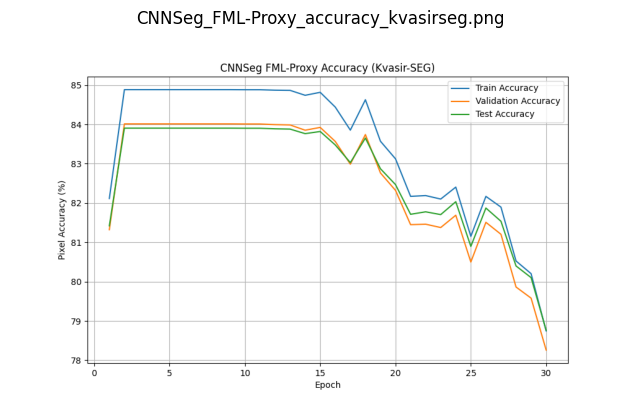

Displaying: CNNSeg_FML-Proxy_loss_kvasirseg.png


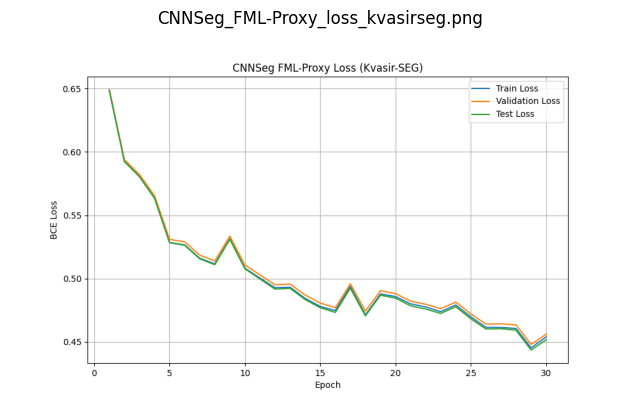

Displaying: CNNSeg_FML-Proxy_roc_kvasirseg.png


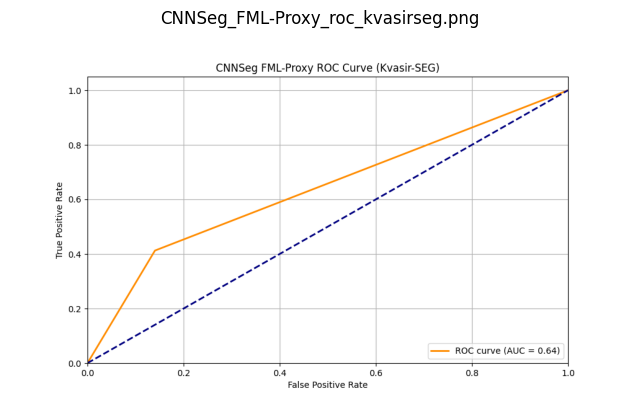

Displaying: CNNSeg_FML-Proxy_cm_kvasirseg.png


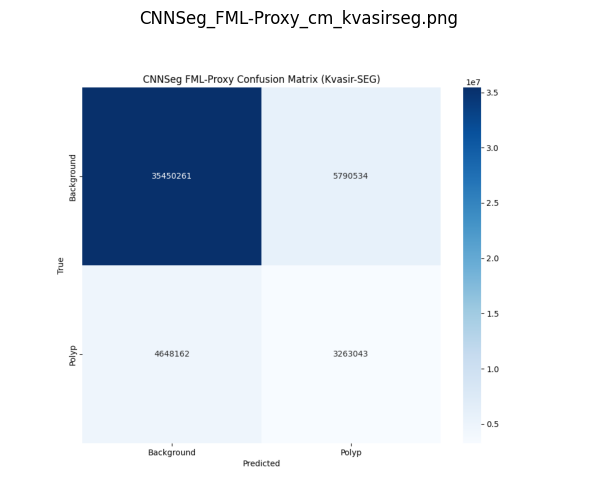

Displaying: LeNetSeg_FedAvg_accuracy_kvasirseg.png


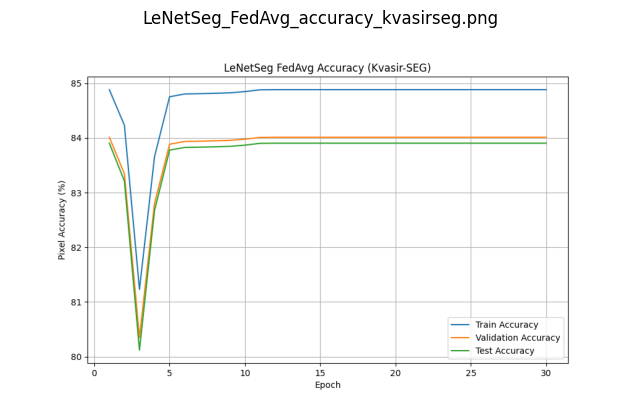

Displaying: LeNetSeg_FedAvg_loss_kvasirseg.png


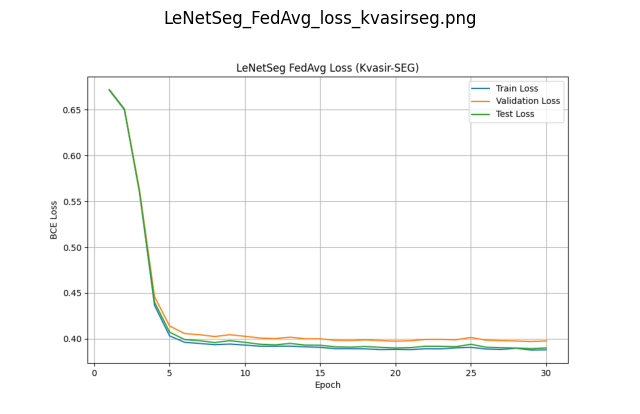

Displaying: LeNetSeg_FedAvg_roc_kvasirseg.png


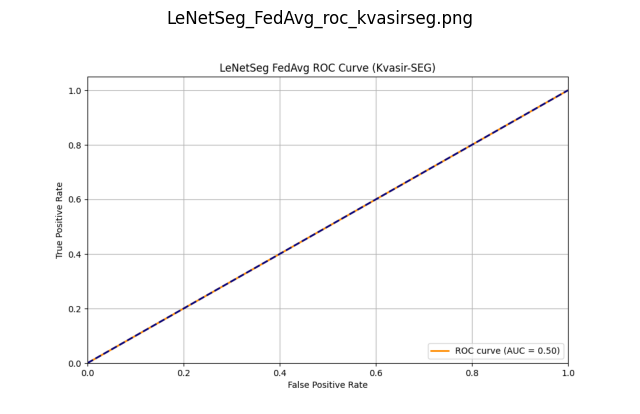

Displaying: LeNetSeg_FedAvg_cm_kvasirseg.png


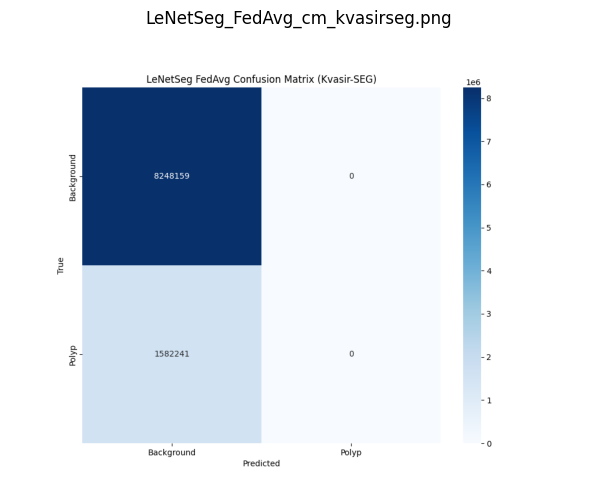

Displaying: LeNetSeg_FML-Proxy_accuracy_kvasirseg.png


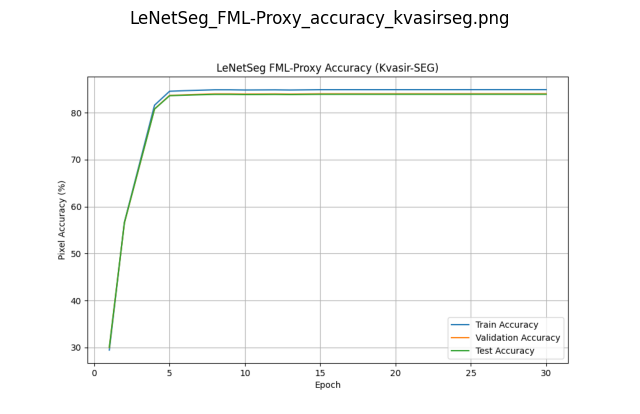

Displaying: LeNetSeg_FML-Proxy_loss_kvasirseg.png


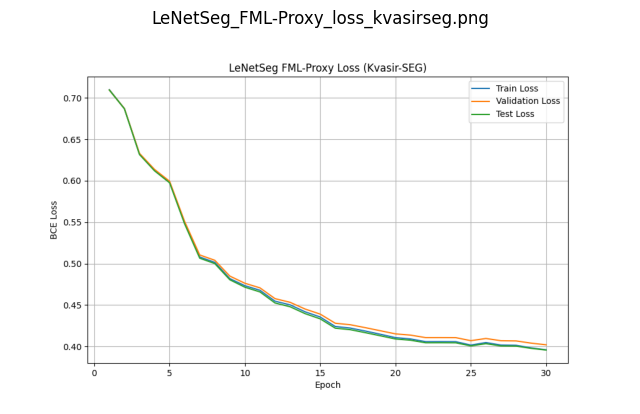

Displaying: LeNetSeg_FML-Proxy_roc_kvasirseg.png


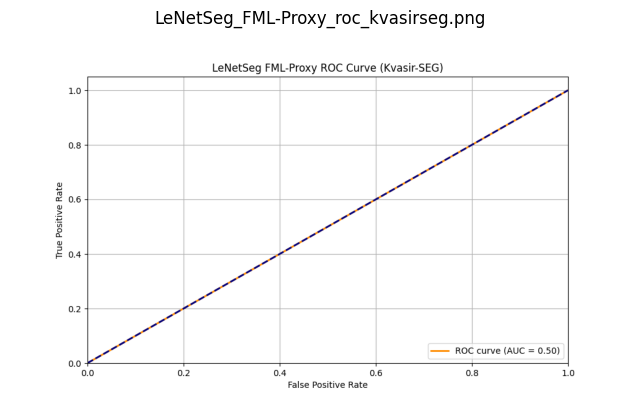

Displaying: LeNetSeg_FML-Proxy_cm_kvasirseg.png


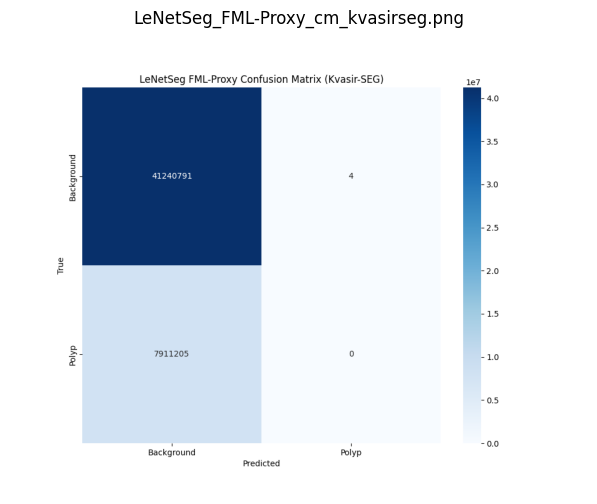

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def display_plots(dataset='KVASIR'):
    # Define models and methods
    models = ['CNNSeg', 'LeNetSeg']
    methods = ['FedAvg', 'FML-Proxy']
    metrics = ['accuracy', 'loss', 'roc', 'cm']  # Adjust metrics based on your code
    datast = 'kvasirseg'

    # Directory where plots are saved
    plot_dir = '/content'  # Update if plots are saved elsewhere (e.g., './plots/')

    # Loop through all combinations
    for model in models:
        for method in methods:
            for metric in metrics:
                # Construct plot filename based on your naming convention
                plot_file = f"{model}_{method}_{metric}_{datast}.png"
                plot_path = os.path.join(plot_dir, plot_file)

                # Check if the plot exists
                if os.path.exists(plot_path):
                    print(f"Displaying: {plot_file}")
                    # Load and display the image
                    img = Image.open(plot_path)
                    plt.figure(figsize=(8, 6))
                    plt.imshow(img)
                    plt.axis('off')  # Hide axes
                    plt.title(plot_file)
                    plt.show()
                else:
                    print(f"Plot not found: {plot_file}")

# Call the function to display MNIST plots
display_plots(dataset='KVASIR')